# **Synthetic Transaction Fraud Detection**



## **Libraries**

In [94]:
!pip install catboost

     |████████████████████████████████| 67.3MB 135kB/s 


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [81]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, learning_curve
from sklearn.metrics import confusion_matrix, precision_score,accuracy_score,f1_score, precision_recall_curve,auc
from sklearn.metrics import average_precision_score, roc_auc_score,roc_curve,recall_score,classification_report 

In [95]:
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from catboost import CatBoostClassifier

In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

---

<br />

## **Reading Data**

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
df = pd.read_csv('/content/gdrive/My Drive/CSE4020 Machine Learning/CSE4020_Project/Dataset/Synthetic_transactions.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', 'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### Number of Records: 6,362,620 (6.3 million transactions)

In [9]:
print("Number of records: {:,}".format(len(df)))

Number of records: 6,362,620


In [10]:
df.isnull().values.any()

False

---

<br />

## **Exploratory Data Analysis**

In [11]:
print("The percentage of fradulent transactions is: ", round((len(df[df["isFraud"]==1])/len(df))*100,3),"%"  )

The percentage of fradulent transactions is:  0.129 %


0    6354407
1       8213
Name: isFraud, dtype: int64


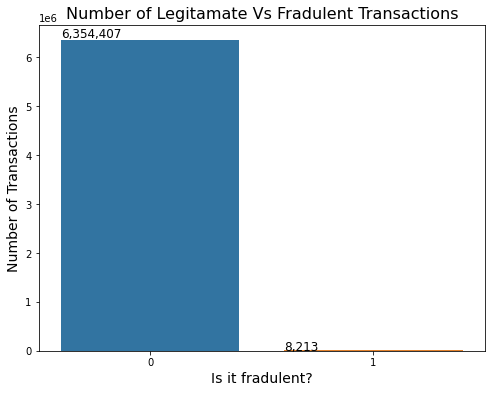

In [31]:
# count number of fraud and not fraud data
print(df.isFraud.value_counts())
plt.figure(figsize=(8,6))
ax = sns.countplot(data=df, x='isFraud')
ax.set_title("Number of Legitamate Vs Fradulent Transactions",fontsize=16)
ax.set_xlabel("Is it fradulent?",fontsize=14)
ax.set_ylabel('Number of Transactions',fontsize=14)

for p in ax.patches:
    ax.annotate( str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01), fontsize=12 )

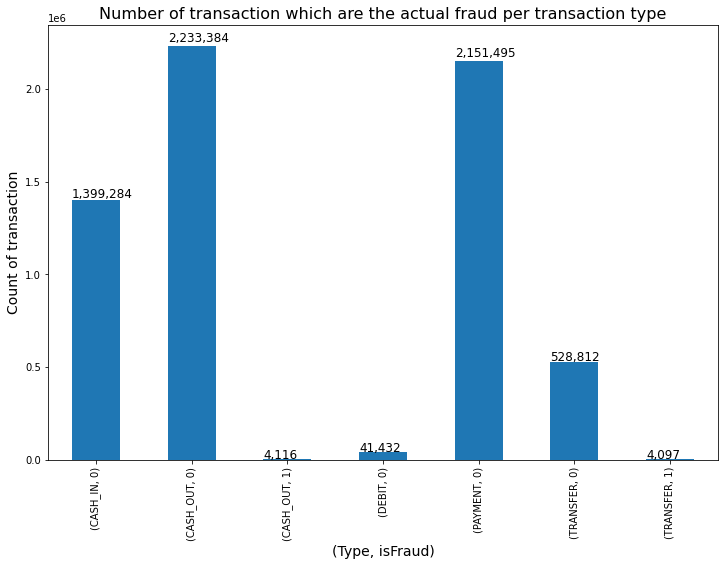

In [32]:
plt.figure(figsize=(12,8))
ax = df.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("Number of transaction which are the actual fraud per transaction type",fontsize=16)
ax.set_xlabel("(Type, isFraud)",fontsize=14)
ax.set_ylabel("Count of transaction",fontsize=14)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01), fontsize=12)

In [33]:
#Groupby type
df.groupby('type')['isFraud','isFlaggedFraud'].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,isFraud,isFlaggedFraud
type,,
CASH_IN,0,0
CASH_OUT,4116,0
DEBIT,0,0
PAYMENT,0,0
TRANSFER,4097,16


In [34]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) # 4116


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


In [35]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 42
np.random.seed(randomState)

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0           
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

In [36]:
X.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00
3,1,1,181.00,181.0,0.0,21182.0,0.00
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44
19,1,0,215310.30,705.0,0.0,22425.0,0.00
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89


In [37]:
Y.head()

2     1
3     1
15    0
19    0
24    0
Name: isFraud, dtype: int64

In [38]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


In [39]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

In [40]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


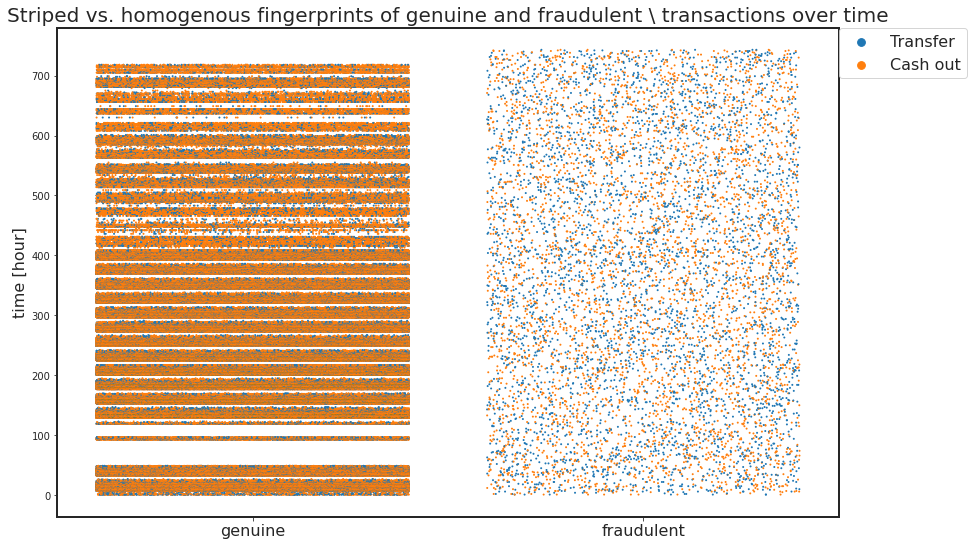

In [22]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \ transactions over time', size = 20);

The plot above shows how the fraudulent and genuine transactions yield different fingerprints when their dispersion is viewed over time. It is clear that fradulent transactions are more homogenously distributed over time compared to genuine transactions. Also apparent is that CASH-OUTs outnumber TRANSFERs in genuine transactions, in contrast to a balanced distribution between them in fraudulent transactions.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


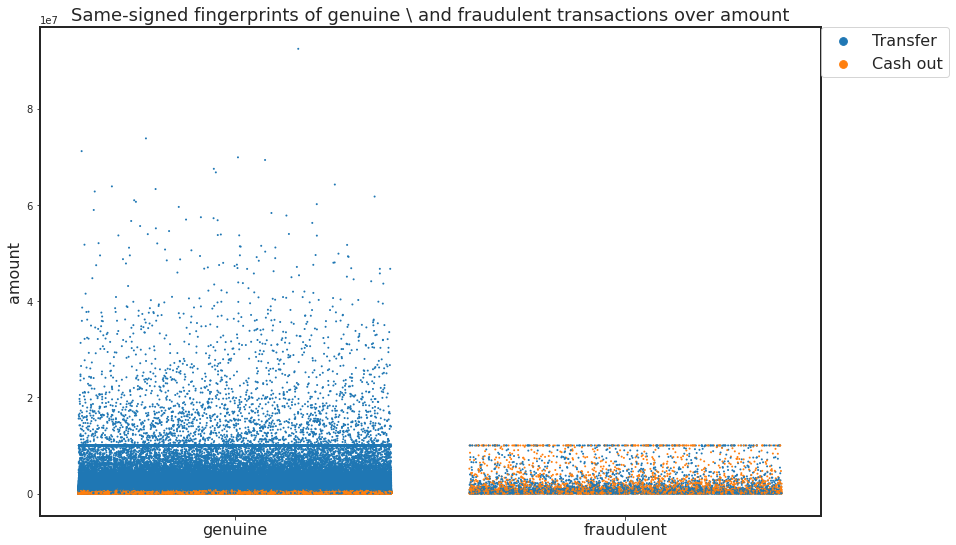

In [23]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \ and fraudulent transactions over amount', size = 18);

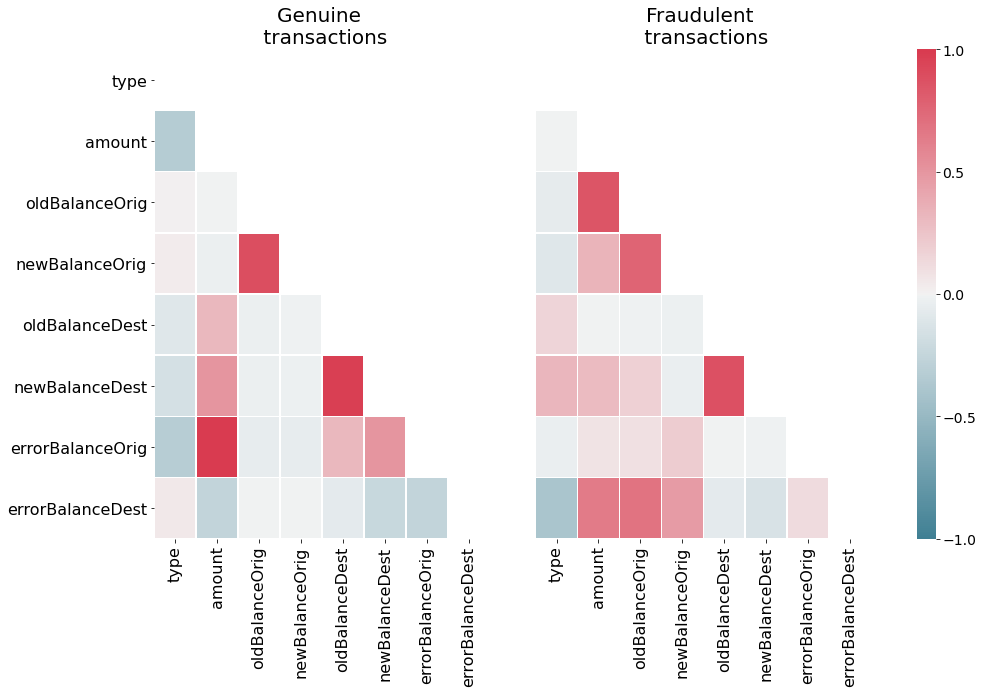

In [24]:
Xfraud = X.loc[Y == 1]            # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

#Matrix Size
grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, figsize = (14, 9))

#Genuine Transactions
cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

#Fradulent Transactions
correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

In [25]:
df_fraud = df.loc[(df.isFraud == 1)]
df_leg = df.loc[(df.isFraud == 1)]
corr_fraud = df_fraud.loc[:, df_fraud.columns != 'step'].corr(method="spearman")

In [26]:
def top_corr(corr,target, n):
  abs_corr = (corr.abs().unstack())[target].to_dict()
  abs_corr.pop(target)
  sorted_corr = dict( sorted(abs_corr.items(), key=lambda item: item[1], reverse=True))
  if n>len(sorted_corr): 
    n = sorted_corr
  sorted_corr = [item for item in sorted_corr.keys()][:n]
  return sorted_corr

In [27]:
temp = top_corr(corr_fraud,"isFraud",5)
print("The top %d factors which affect the target are: "%(len(temp)))
for item in temp:
  print("-> ",item) 

The top 5 factors which affect the target are: 
->  amount
->  oldBalanceOrig
->  newBalanceOrig
->  oldBalanceDest
->  newBalanceDest


---

<br />

## **Models**

In [41]:
data_counts = Counter(Y)
print("Legitimate: {:,}".format(data_counts[0]))
print("Fraudulent: {:,}".format(data_counts[1]))

Legitimate: 2,762,196
Fraudulent: 8,213


### **1. Logistic Regression**

#### **A. Under Sampling Data**

In [42]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X, Y)
X_under, Y_under = rus.fit_resample(X, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [43]:
data_under = Counter(Y_under)
print("Legitimate: {:,}".format(data_under[0]))
print("Fraudulent: {:,}".format(data_under[1]))

Legitimate: 8,213
Fraudulent: 8,213


In [44]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under,Y_under,test_size = 0.2,random_state = 0)
print("Number transactions train dataset: ", format(len(X_train_under),',d'))
print("Number transactions test dataset: ", format(len(X_test_under),',d'))
print("Total number of transactions: ", format(len(X_train_under)+len(X_test_under),',d'))

Number transactions train dataset:  13,140
Number transactions test dataset:  3,286
Total number of transactions:  16,426


In [ ]:
def printing_Kfold_scores(x_train_data, y_train_data, kfoldnum, c_array):
    # define K-Fold
    fold = KFold(n_splits=kfoldnum, shuffle = False) 

    results_table = pd.DataFrame(index = range(len(c_array),3), columns = ['C_parameter','Mean recall score', 'Mean precision score'])
    results_table['C_parameter'] = c_array

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_array:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        precision_accs = []
        for iteration, indices in enumerate(fold,start=1):

            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C = c_param, penalty = 'l1')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())

            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            
            precision_acc = precision_score(y_train_data.iloc[indices[1], :].values, y_pred_undersample)
            precision_accs.append(precision_acc)
            print("Iteration {}: recall score = {:.4f}, precision score = {:.4f}".format(iteration, recall_acc, precision_acc))

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.ix[j,'Mean recall score'] = np.mean(recall_accs)
        results_table.ix[j, 'Mean precision score'] = np.mean(precision_accs)
        j += 1
        print('')
        print('Mean recall score {:.4f}'.format(np.mean(recall_accs)))
        print('Mean precision score {:.4f}'.format(np.mean(precision_accs)))
        print('')

    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter']
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [ ]:
c_param_range = [0.001, 0.01, 0.1, 1, 10, 100]
k_fold = 5
best_c = printing_Kfold_scores(X_train_under, y_train_under, k_fold, c_param_range)

In [57]:
lr_under = LogisticRegression()
lr_under.fit(X_train_under, y_train_under)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
y_pred_under = lr_under.predict(X_test_under)

In [67]:
def model_result(clf,x_test,y_test):
    y_prob=clf.predict_proba(x_test)
    y_pred=clf.predict(x_test)
    auprc = round((average_precision_score(y_test, y_prob[:, 1])),3)
    f1 = round(f1_score(y_test,y_pred),3)
    acc = round(accuracy_score(y_test,y_pred),3)
    recall = round(recall_score(y_test, y_pred, average='micro'),3)

    print('AUPRC :', auprc)
    print('F1 - score :', f1)
    print("Accuracy Score: ", acc)
    print("Recall Score: ", recall)
    print("\nClassification Report:")
    print(classification_report(y_test,y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (10,7))
    sns.heatmap(cm, annot=True, annot_kws={"size": 16},
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            linewidth=1,
            linecolor='black',
            cmap ="Blues"
            )
    plt.title("Confusion matrix",fontsize=16)
    return {'auprc': auprc, 'f1':f1, 'accuracy':acc, 'recall':recall}


Test Results: 

AUPRC : 0.976
F1 - score : 0.925
Accuracy Score:  0.921
Recall Score:  0.921

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.92      1630
           1       0.89      0.97      0.92      1656

    accuracy                           0.92      3286
   macro avg       0.92      0.92      0.92      3286
weighted avg       0.92      0.92      0.92      3286



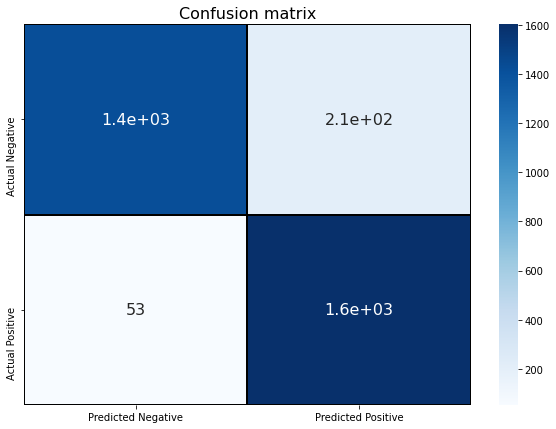

In [69]:
print ('\nTest Results: \n')
lr_under_results = model_result(lr,X_test_under,y_test_under)

#### **B. Oversampling (SMOTE)**

In [50]:
from imblearn.over_sampling import SMOTE

In [51]:
oversample = SMOTE()
X_over, Y_over = oversample.fit_resample(X, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [52]:
data_over = Counter(Y_over)
print("Legitimate: {:,}".format(data_over[0]))
print("Fraudulent: {:,}".format(data_over[1]))

Legitimate: 2,762,196
Fraudulent: 2,762,196


In [53]:
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over,Y_over, test_size = 0.2, random_state = 0)
print("Number transactions train dataset: ", format(len(X_train_over),',d'))
print("Number transactions test dataset: ", format(len(X_test_over),',d'))
print("Total number of transactions: ", format(len(X_train_over)+len(X_test_over),',d'))

Number transactions train dataset:  4,419,513
Number transactions test dataset:  1,104,879
Total number of transactions:  5,524,392


In [54]:
lr_over = LogisticRegression()
lr_over.fit(X_train_over, y_train_over)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
y_pred_over = lr_over.predict(X_test_over)


Test Results: 

AUPRC : 0.977
F1 - score : 0.931
Accuracy Score:  0.928
Recall Score:  0.928

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.92    553120
           1       0.89      0.97      0.93    551759

    accuracy                           0.93   1104879
   macro avg       0.93      0.93      0.93   1104879
weighted avg       0.93      0.93      0.93   1104879



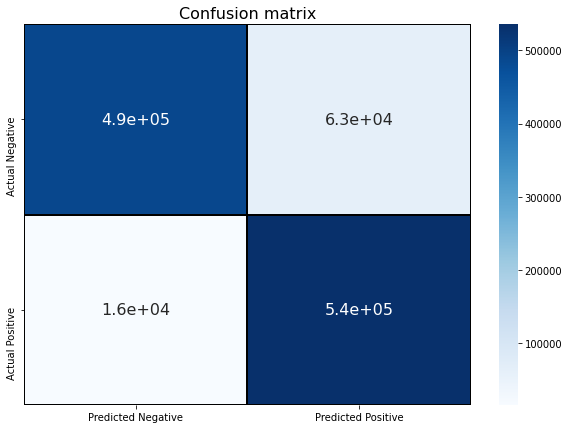

In [70]:
print ('\nTest Results: \n')
lr_over_results = model_result(lr_over,X_test_over,y_test_over)

### **2. Random Forest**

In [80]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, Y, test_size = 0.3,random_state=42, shuffle=False)

In [82]:
rf=RandomForestClassifier()
rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

AUPRC : 1.0
F1 - score : 1.0
Accuracy Score:  1.0
Recall Score:  1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    826543
           1       1.00      1.00      1.00      4580

    accuracy                           1.00    831123
   macro avg       1.00      1.00      1.00    831123
weighted avg       1.00      1.00      1.00    831123



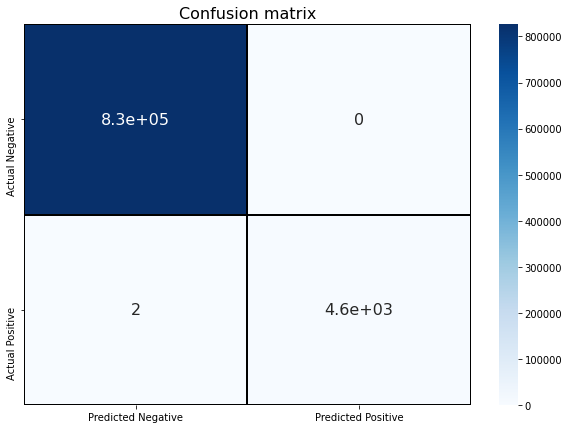

In [86]:
rf_results = model_result(rf,X_test_rf,y_test_rf)

### **3. XGBoost**

In [63]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, Y, test_size = 0.2, random_state = 0)

print("Number transactions train dataset: ", format(len(X_train_xgb),',d'))
print("Number transactions test dataset: ", format(len(X_test_xgb), ',d'))
print("Total number of transactions: ", format(len(X_train_xgb)+len(X_test_xgb), ',d'))

Number transactions train dataset:  2,216,327
Number transactions test dataset:  554,082
Total number of transactions:  2,770,409


In [64]:
xgb = XGBClassifier()
xgb.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

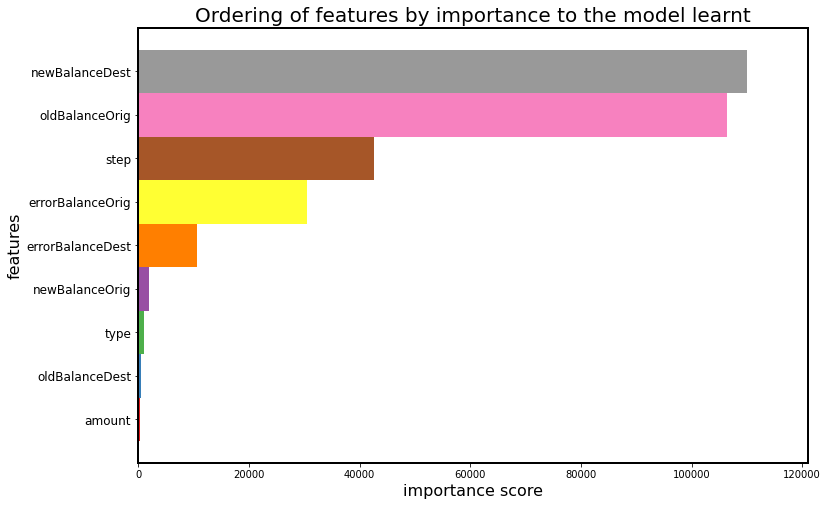

In [87]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(xgb, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

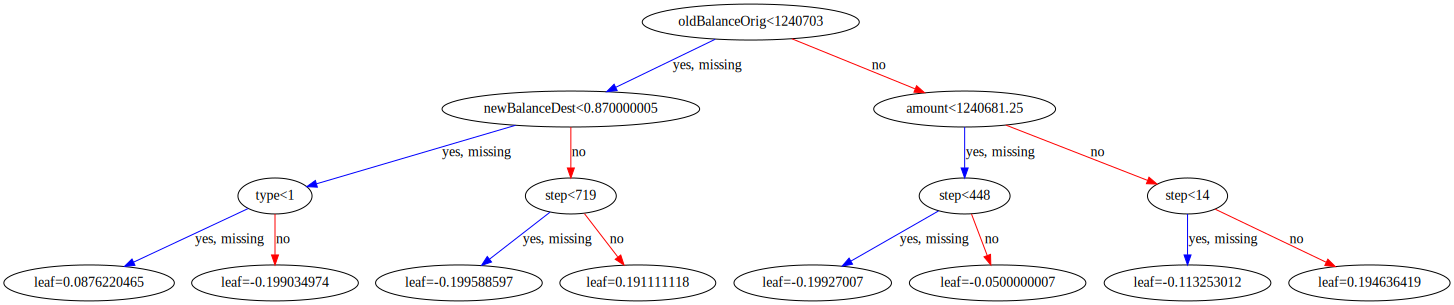

In [88]:
to_graphviz(xgb)


Test Results: 

AUPRC : 0.999
F1 - score : 0.999
Accuracy Score:  1.0
Recall Score:  1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552446
           1       1.00      1.00      1.00      1636

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



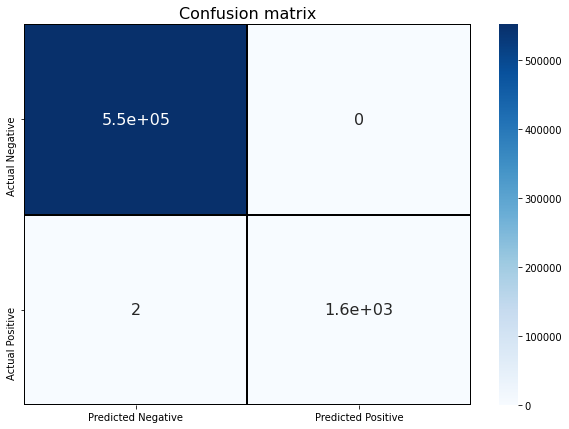

In [68]:
print ('\nTest Results: \n')
xgb_results = model_result(xgb,X_test_xgb,y_test_xgb)

In [93]:
%time
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
trainSizes, trainScores, crossValScores = learning_curve(XGBClassifier(n_jobs = 4, max_depth = 3,scale_pos_weight = weights), 
                                                         X_train_xgb, y_train_xgb, scoring = 'average_precision')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


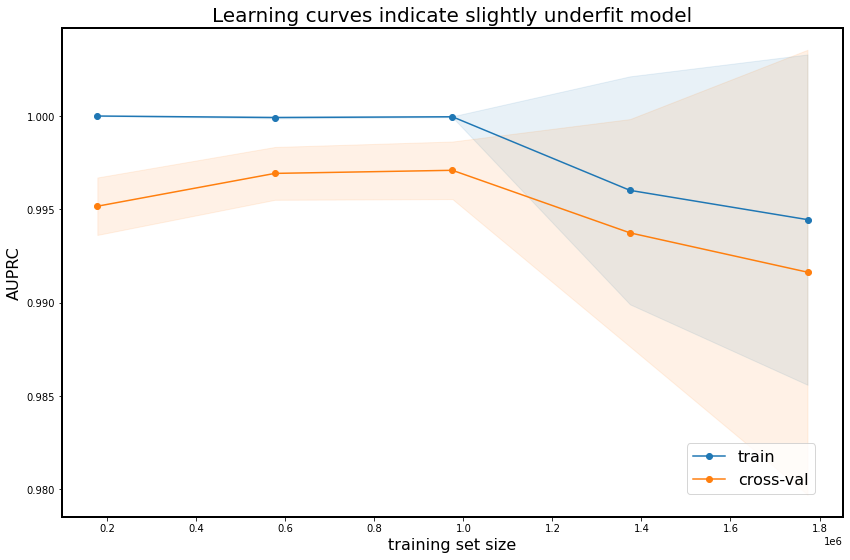

In [96]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd, trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd, crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);

### **4. CATBoost**

In [97]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, Y, test_size = 0.2,random_state=0)

In [98]:
model_cat = CatBoostClassifier(iterations=10, learning_rate=1, depth=2)
model_cat.fit(X_train_cat,y_train_cat)

0:	learn: 0.1320072	total: 470ms	remaining: 4.23s
1:	learn: 0.0475967	total: 761ms	remaining: 3.04s
2:	learn: 0.0207490	total: 1.02s	remaining: 2.38s
3:	learn: 0.0065175	total: 1.3s	remaining: 1.95s
4:	learn: 0.0034457	total: 1.56s	remaining: 1.56s
5:	learn: 0.0011548	total: 1.82s	remaining: 1.21s
6:	learn: 0.0007756	total: 2.08s	remaining: 890ms
7:	learn: 0.0003760	total: 2.33s	remaining: 584ms
8:	learn: 0.0003478	total: 2.58s	remaining: 287ms
9:	learn: 0.0002331	total: 2.84s	remaining: 0us



Test Results: 

AUPRC : 0.999
F1 - score : 0.999
Accuracy Score:  1.0
Recall Score:  1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552446
           1       1.00      1.00      1.00      1636

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



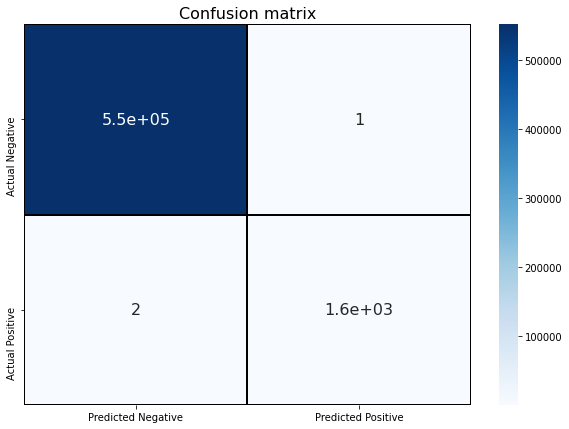

In [99]:
print ('\nTest Results: \n')
cat_results = model_result(model_cat,X_test_cat,y_test_cat)

---

<br />

## **Results**

In [101]:
label_cols = ["Model", "Accuracy", "Recall", "F-Score", "AUPRC"]
label_rows = ["Logistic Regression (Under)","Logistic Regression (Over)", "XGBoost","Random Forest", "CatBoost"] #, "CatBoost"
acc = [lr_under_results["accuracy"], lr_over_results["accuracy"], xgb_results["accuracy"], rf_results["accuracy"], cat_results["accuracy"]]
recall = [lr_under_results["recall"], lr_over_results["recall"], xgb_results["recall"], rf_results["recall"], cat_results["recall"]]
auprc = [lr_under_results["auprc"], lr_over_results["auprc"], xgb_results["auprc"], rf_results["auprc"], cat_results["auprc"]]
f_scores = [lr_under_results["f1"], lr_over_results["f1"], xgb_results["f1"], rf_results["f1"], cat_results["f1"]]

In [102]:
results = pd.DataFrame({"Model":label_rows, "Accuracy": acc, "Recall":recall, "F-Scores":f_scores, "AUPRC":auprc})
results.columns = label_cols
results.head(5)

,Model,Accuracy,Recall,F-Score,AUPRC
0,Logistic Regression (Under),0.921,0.921,0.925,0.976
1,Logistic Regression (Over),0.928,0.928,0.931,0.977
2,XGBoost,1.000,1.000,0.999,0.999
3,Random Forest,1.000,1.000,1.000,1.000
4,CatBoost,1.000,1.000,0.999,0.999
